In [50]:
import torch, torchvision, torchinfo, pandas as pd, numpy as np, matplotlib.pyplot as plt, random

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image

In [2]:
image_with_label = pd.read_csv("../data/train.csv")
image_with_label

Unnamed: 0                                        file_name  label
0               0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1               1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2               2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3               3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4               4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
...           ...                                              ...    ...
79945       79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0
79946       79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1
79947       79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0
79948       79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1
79949       79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0

[79950 rows x 3 columns]

In [3]:
image_with_label.drop(columns=["Unnamed: 0"], inplace=True)
image_with_label

file_name  label
0      train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1      train_data/041be3153810433ab146bc97d5af505c.jpg      0
2      train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3      train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4      train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
...                                                ...    ...
79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0
79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1
79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0
79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1
79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0

[79950 rows x 2 columns]

In [4]:
DEFAULT_TRANSFORMER = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomDataset(Dataset):
    def __init__(self, image_with_label, images_dir="../data/", transformer=DEFAULT_TRANSFORMER):
        super(CustomDataset, self).__init__()
        self.image_with_label = image_with_label
        self.images_dir = images_dir
        self.transformer = transformer

    def __len__(self):
        return self.image_with_label.shape[0]

    def load_image(self, path):
        image = Image.open(self.images_dir + path)
        if self.transformer is None:
            return image
        return self.transformer(image)

    def __getitem__(self, index):
        file_path, label = self.image_with_label.iloc[index]
        image = self.load_image(file_path)
        if image.shape[0] < 3:
            return self.__getitem__(index+1)
        return image, label

In [5]:
whole_dataset = CustomDataset(image_with_label)
len(whole_dataset)

79950

torch.Size([3, 64, 64]) 1


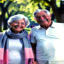

In [6]:
x, y = whole_dataset[0]
print(x.shape, y)

transforms.ToPILImage()(x)

In [7]:
TOTAL_LENGTH = len(whole_dataset)
VAL_LENGTH = int(TOTAL_LENGTH * 0.1)
TRAIN_LENGTH = int(TOTAL_LENGTH - VAL_LENGTH)

TOTAL_LENGTH, TRAIN_LENGTH, VAL_LENGTH

(79950, 71955, 7995)

In [8]:
train_dataset, val_dataset = torch.utils.data.random_split(whole_dataset, lengths=[TRAIN_LENGTH, VAL_LENGTH])

len(train_dataset), len(val_dataset)

(71955, 7995)

In [9]:
BATCH_SIZE = 32

def filter_condition(inputs):
    x, y = inputs
    # print(x.shape[0])
    return x.shape[0] == 3
    
def my_collate_fn(batch):
    batch = list(filter(filter_condition, batch))
    return torch.utils.data.dataloader.default_collate(batch)  

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=my_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=my_collate_fn)

train_dataloader

In [10]:
x, y = next(iter(train_dataloader))
x.shape, y

(torch.Size([32, 3, 64, 64]),
 tensor([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
         1, 1, 0, 0, 0, 1, 1, 1]))

In [27]:
(64 / 16) ** 2, 16 ** 2 * 3

(16.0, 768)

In [16]:
HEIGHT = 64
WIDTH = 64
PATCH_SIZE = 16
NUM_PATCHES = (HEIGHT / PATCH_SIZE) ** 2
EMBEDDING_SIZE = (PATCH_SIZE ** 2) * 3

NUM_PATCHES, EMBEDDING_SIZE

(16.0, 768)

In [32]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, embedding_dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        self.conv_layer = nn.Conv2d(in_channels=in_channels,
                                   out_channels=embedding_dim,
                                   kernel_size=patch_size,
                                   stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        return self.flatten(self.conv_layer(x)).permute(0, 2, 1)

In [43]:
class MultiHeadSelfAttentitionBlock(nn.Module):
    def __init__(self, embedding_dim, num_head, dropout:float=0.1):
        super().__init__()
        self.norm_layer = nn.LayerNorm(embedding_dim)
        self.multi_atten = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_head,
                                                dropout=dropout)

    def forward(self, x):
        x = self.norm_layer(x)
        atten_output, _ = self.multi_atten(x, x, x, need_weights=False)
        return atten_output

In [62]:
class MultiLayerPerceptronBlock(nn.Module):
    def __init__(self, in_features, embedding_dim, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.mlp_layer = nn.Sequential(
            nn.Linear(in_features=embedding_dim, 
                      out_features=in_features),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=in_features,
                     out_features=embedding_dim)
        )

    def forward(self, x):
        return self.mlp_layer(self.layer_norm(x))

In [63]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_head, mlp_hidden_units, msa_dropout=0.1, mlp_dropout=0.1):
        super().__init__()
        self.msa = MultiHeadSelfAttentitionBlock(embedding_dim,
                                                num_head,
                                                msa_dropout)
        self.mlp = MultiLayerPerceptronBlock(mlp_hidden_units,
                                            embedding_dim,
                                            mlp_dropout)

    def forward(self, x):
        x = self.msa(x) + x
        x = self.mlp(x) + x
        return x

Input shape: torch.Size([3, 64, 64])
patched_img: torch.Size([1, 16, 768])
class_embedding: torch.Size([1, 1, 768])
patched_img_class: torch.Size([1, 17, 768])
position_embedding: torch.Size([1, 17, 768])
patched_img_class_pos: torch.Size([1, 17, 768])
label: 1


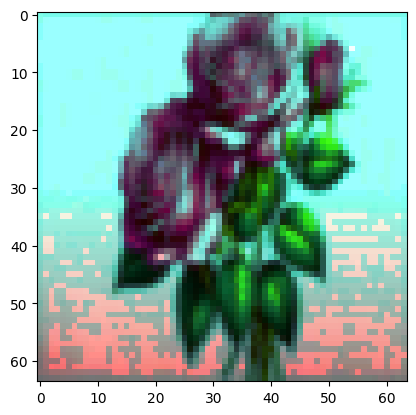

In [64]:
BATCH_SIZE = 32
PATCH_SIZE = 16
HEIGHT = 64
WIDTH = 64
NUM_OF_PATCHES = int(WIDTH * HEIGHT) / PATCH_SIZE ** 2
RESOLUTION = (PATCH_SIZE ** 2) * 3

index = random.choice(range(len(train_dataset)))
image, label = train_dataset[index]
print(f"Input shape: {image.shape}")

patcher = PatchEmbeddingLayer(3, RESOLUTION, PATCH_SIZE)
patched_img = patcher(image.unsqueeze(0))
print(f"patched_img: {patched_img.shape}")

class_embedding = nn.Parameter(torch.randn(patched_img.shape[0], 1, patched_img.shape[-1]))
print(f"class_embedding: {class_embedding.shape}")

patched_img_class = torch.cat((class_embedding, patched_img), dim=1)
print(f"patched_img_class: {patched_img_class.shape}")

position_embedding = nn.Parameter(torch.randn(patched_img.shape[0], patched_img_class.shape[1], patched_img_class.shape[-1]))
print(f"position_embedding: {position_embedding.shape}")

patched_img_class_pos = patched_img_class + position_embedding
print(f"patched_img_class_pos: {patched_img_class_pos.shape}")

print(f"label: {label}")
plt.imshow(image.permute(1, 2, 0))

In [65]:
# Eqn 2

# Create an instance of MSABlock
multihead_self_attention_block = MultiHeadSelfAttentitionBlock(768, # from Table 1
                                                             12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patched_img_class_pos)
print(f"Input shape of MSA block: {patched_img_class_pos.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 17, 768])
Output shape MSA block: torch.Size([1, 17, 768])


In [66]:
# Create an instance of MLPBlock
mlp_block = MultiLayerPerceptronBlock(3072,
                                      768,
                                      0.1)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 17, 768])
Output shape MLP block: torch.Size([1, 17, 768])


In [67]:
class VisionTransformer(nn.Module):
    def __init__(self, 
                 input_shape=3,
                 image_size=224,
                 patch_size=16,
                 msa_head=12,
                 msa_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 mlp_hidden_units=3072,
                 num_transformer_block=12,
                 num_classes=2):
        super().__init__()
        self.embedding_dim = int((patch_size ** 2) * 3)
        self.num_patches = int((image_size ** 2) / (patch_size ** 2))
        self.patcher = PatchEmbeddingLayer(3, self.embedding_dim, patch_size)
        self.class_token_embedding = nn.Parameter(
            torch.randn(1, 1, self.embedding_dim)
        )
        self.position_eembedding = nn.Parameter(
            torch.randn(1, self.num_patches + 1, self.embedding_dim)
        )
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.transformer_encoder = nn.Sequential(*[
            TransformerEncoderBlock(self.embedding_dim,
                                   msa_head,
                                   mlp_hidden_units,
                                   msa_dropout,
                                   mlp_dropout)
            for _ in range(num_transformer_block)
        ])
        self.classifer_layer = nn.Sequential(
            nn.LayerNorm(self.embedding_dim),
            nn.Linear(in_features=self.embedding_dim,
                     out_features=num_classes)
        )

    def forward(self, x):
        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_token_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patcher(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_eembedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifer_layer(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [74]:
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(DEVICE)

model = VisionTransformer(num_classes=2, image_size=64).to(DEVICE)

torchinfo.summary(model=model,
        input_size=(BATCH_SIZE, 3, 64, 64), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

cpu


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                   [32, 3, 64, 64]      [32, 2]              13,824               True
├─PatchEmbeddingLayer (patcher)                         [32, 3, 64, 64]      [32, 16, 768]        --                   True
│    └─Conv2d (conv_layer)                              [32, 3, 64, 64]      [32, 768, 4, 4]      590,592              True
│    └─Flatten (flatten)                                [32, 768, 4, 4]      [32, 768, 16]        --                   --
├─Dropout (embedding_dropout)                           [32, 17, 768]        [32, 17, 768]        --                   --
├─Sequential (transformer_encoder)                      [32, 17, 768]        [32, 17, 768]        --                   True
│    └─TransformerEncoderBlock (0)                      [32, 17, 768]        [32, 17, 768]        --                   True
│    │ 

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

In [ ]:
EPOCHS = 2

history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

train_start = timer()

for epoch in tqdm(range(EPOCHS)):
    epoch_start = timer()
    
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    model.train()
    
    for batch, (train_x, train_y) in enumerate(train_dataloader):
        train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
        
        train_preds = model(train_x)

        loss = loss_fn(train_preds, train_y)

        train_loss += loss
        train_acc += (torch.argmax(torch.softmax(train_preds, dim=1), dim=1) == train_y).sum().item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 700 == 0:
            print(f"Epoch: {epoch} | Batch: {batch} | Train Loss: {train_loss / (batch + 1)} | Train Accuracy: {train_acc / ((batch + 1) * BATCH_SIZE)}")
    
    train_acc /= len(train_dataset)
    train_loss /= len(train_dataset)
    
    history["epoch"].append(epoch)
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)

    model.eval()
    with torch.inference_mode():
        for val_x, val_y in val_dataloader:
            val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
            
            val_preds = model(val_x)

            val_loss += loss_fn(val_preds, val_y)
            val_acc += (torch.argmax(torch.softmax(val_preds, dim=1), dim=1) == val_y).sum().item()
            
        val_acc /= len(val_dataset)
        val_loss /= len(val_dataset)

        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)

        epoch_end = timer()

        print(f"{epoch_end - epoch_start:.1f}/s Train Accuracy: {train_acc} | Train Loss: {train_loss} | Val Loss: {val_loss} | Val Accuracy: {val_acc}")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0 | Train Loss: 0.7314748764038086 | Train Accuracy: 0.4375
Epoch: 0 | Batch: 700 | Train Loss: 0.7010901570320129 | Train Accuracy: 0.4999554208273894
